In [1]:
# Imports and scripts
import pandas as pd
#import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
import pathmagic
%matplotlib inline
with pathmagic.context():
    import Preprocess as Prep
    import RelativePaths as RP
    import Evaluation as Eva
    import GatherData as Gather
    import Graphs
    import Utils
import ray
#ray.shutdown()
#ray.init()

system = 'prom'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Laoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# File containing settings
path_to_yaml = '../config.yaml'
config = Utils.read_yaml_file(path_to_yaml)

files = config['file locations'][system]
preprocess_settings = config['preprocess settings list']

In [3]:
# set file_locations which will be relative to computer in use
from pathlib import Path

system_folder = str(Path.cwd().parent / files['system folder'])

raw_data_csv = str(Path.cwd().parent / files['raw data'])
tmp_csv = str(Path.cwd().parent / files['tmp data'])

processed_data_csv = str(Path.cwd().parent / files['single setting preprocessing'])

In [4]:
Gather.gather_architectural_concerns_data(system_folder, raw_data_csv)

Text(0.5, 1.0, 'System: ProM')

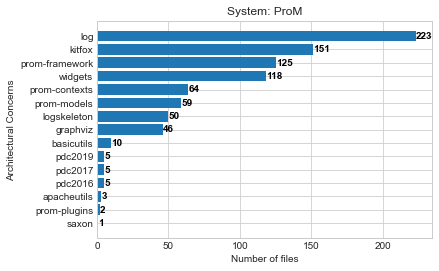

In [5]:
import re
def name_filter(name_list):
    res = []
    rule = r"[a-zA-Z]+(?:\w+)"
    for name in name_list:
        tmp = re.findall(rule, name)
        res.append('-'.join(tmp))  
    return res


dataset_df = pd.read_csv(raw_data_csv)
y_labels = dataset_df.Label.unique()
x_quantity = [len(dataset_df.loc[dataset_df['Label']==label]) for label in y_labels]

y_labels = name_filter(y_labels)

tmp_df = pd.DataFrame({
    'Labels' : y_labels,
    'Quantity' : x_quantity
})
tmp_df = tmp_df.sort_values(by=['Quantity'])
plt.style.use("seaborn-whitegrid")
plt.barh(y=tmp_df.Labels, width=tmp_df.Quantity)
for i, v in enumerate(tmp_df.Quantity):
    plt.text(v, i, str(v), color='black', fontweight='bold', ha='left', va='center')

plt.xlabel('Number of files')
plt.ylabel('Architectural Concerns')
plt.title('System: ProM')

----

# Evaluation

### Static parts
__Train-test split,__ will be set at 10% for training, and 90% for evaluation.  
* __Metrics,__ the most relevant ones will be the following:  
   * Confusion matrix  
   * Precission  
   * Accuracy  
   * F1-score/value  
   * Average score 
    
----

# TEST

In [6]:
setting = preprocess_settings['s0']
Prep.preprocess_settings(setting, raw_data_csv, processed_data_csv)

,FileName,Label,FileContent
0,Apache20LicenseHelp.java,apacheutils-6.9.122,"[org, processmining, help]"
1,Apache20License.java,apacheutils-6.9.122,"[io, buffer, reader, io, ioexcept, io, input, ..."
2,Apache20LicensePlugin.java,apacheutils-6.9.122,"[org, processmin, context, uitopia, uiplugin, ..."
3,LGPLLicenseHelp.java,basicutils-6.9.126,"[org, processmining, basicutils, help]"
4,ObjectArrayImpl.java,basicutils-6.9.126,"[io, file, io, input, stream, io, input, strea..."
...,...,...,...
862,AbstractRoutableDialog.java,widgets-6.9.234,"[org, processmin, context, uitopia, uiplugin, ..."
863,Dialog.java,widgets-6.9.234,"[javax, swing, jcompon, org, processmin, conte..."
864,Route.java,widgets-6.9.234,"[org, processmining, widgets, wizard]"
865,Wizard.java,widgets-6.9.234,"[org, deckfour, uitopia, api, event, task, lis..."


In [7]:
test_df = pd.read_csv(processed_data_csv)
# Remove GLOBALS and CLI from the dataset
df_sliced = Utils.remove_concerns_under_quantity_threshold(test_df)
test_size=0.9
fold_quantity = 100
feature_representation = CountVectorizer()
confusion_list = []

# Train and gather evaluation metrics
evaluate = Eva.Evaluation(df_sliced, feature_representation, test_size, fold_quantity, 10)
classifier_max_ent , metrics_max_ent = evaluate.evaluate_MaxEnt()
classifier_svm , metrics_svm = evaluate.evaluate_SVM()
classifier_naive, metrics_naive = evaluate.evaluate_Naive_Bayes()

metrics = {
    'maxEnt': metrics_max_ent,
    'SVM': metrics_svm,
    'Naive': metrics_naive
}

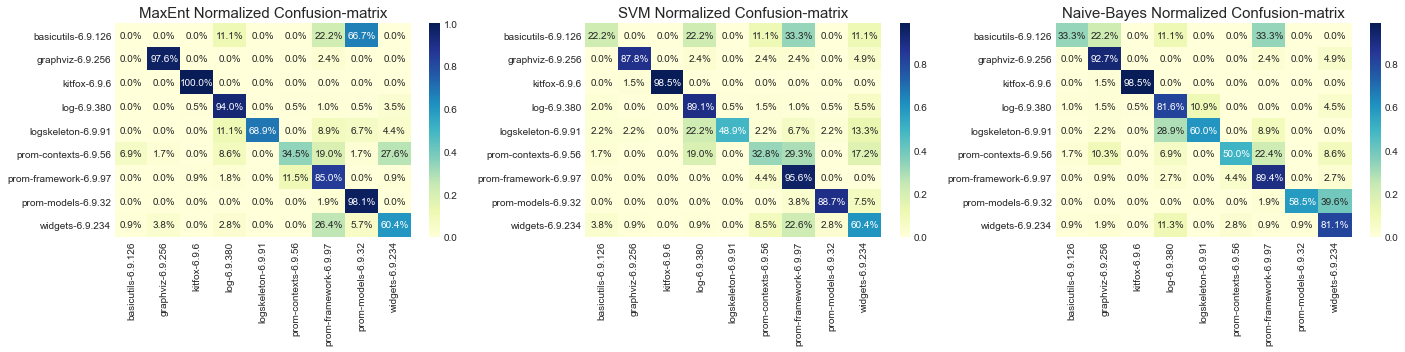

In [8]:
Graphs.plot_horizontal_graphs(metrics, 'norm')

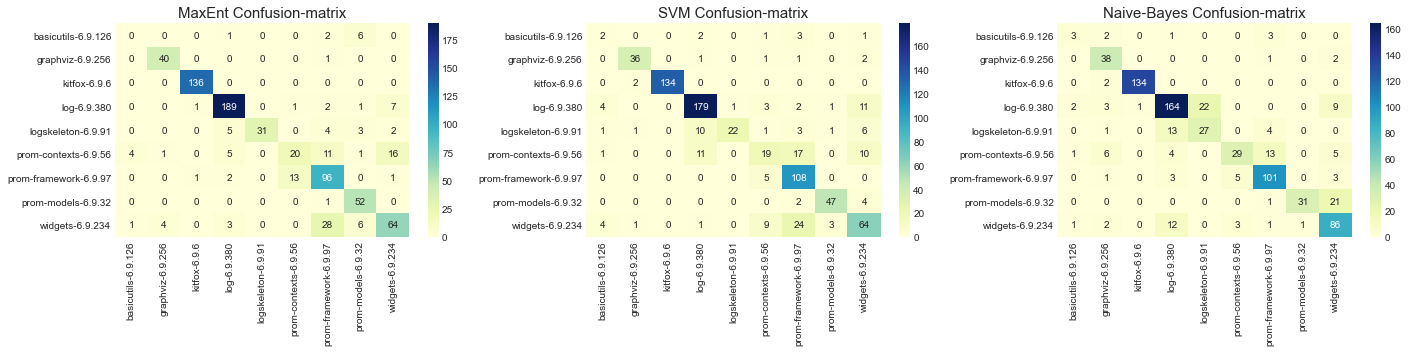

In [9]:
Graphs.plot_horizontal_graphs(metrics, 'regular')

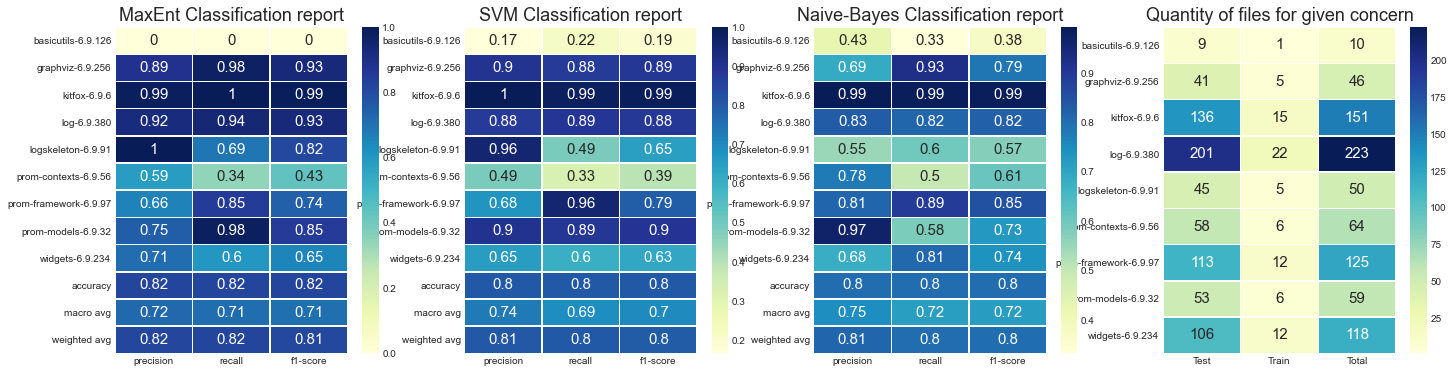

<Figure size 432x288 with 0 Axes>

In [10]:
Graphs.plot_horizontal_graphs(metrics, 'report')

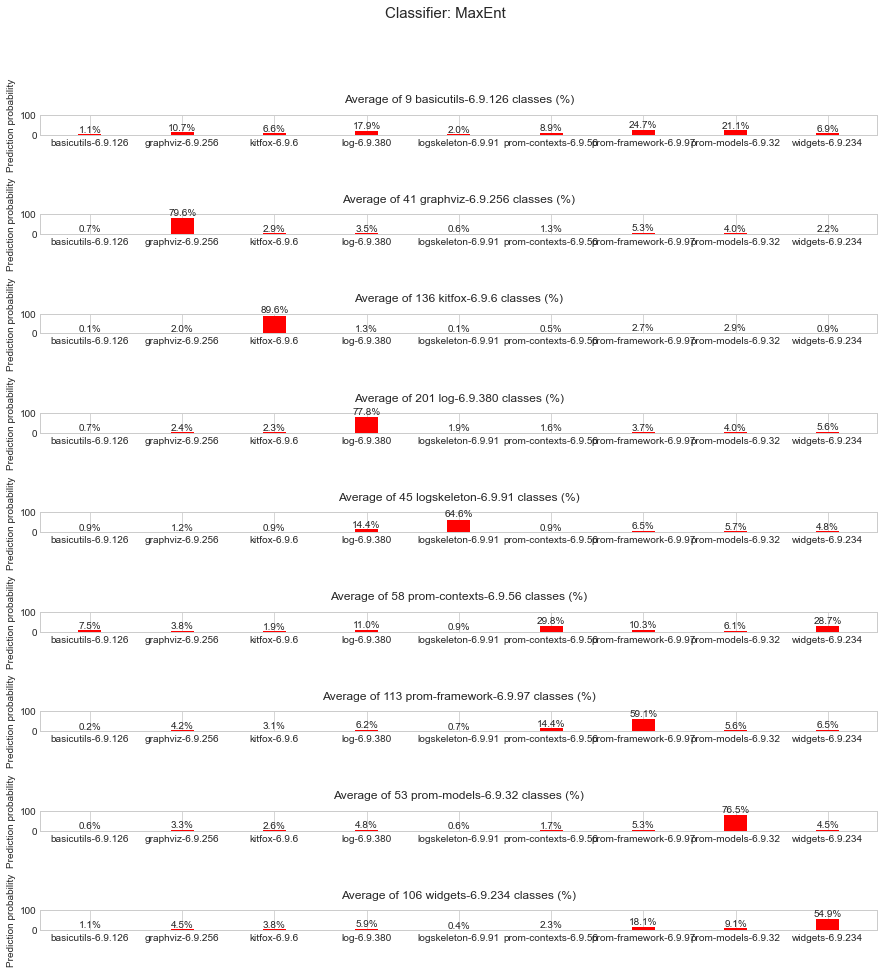

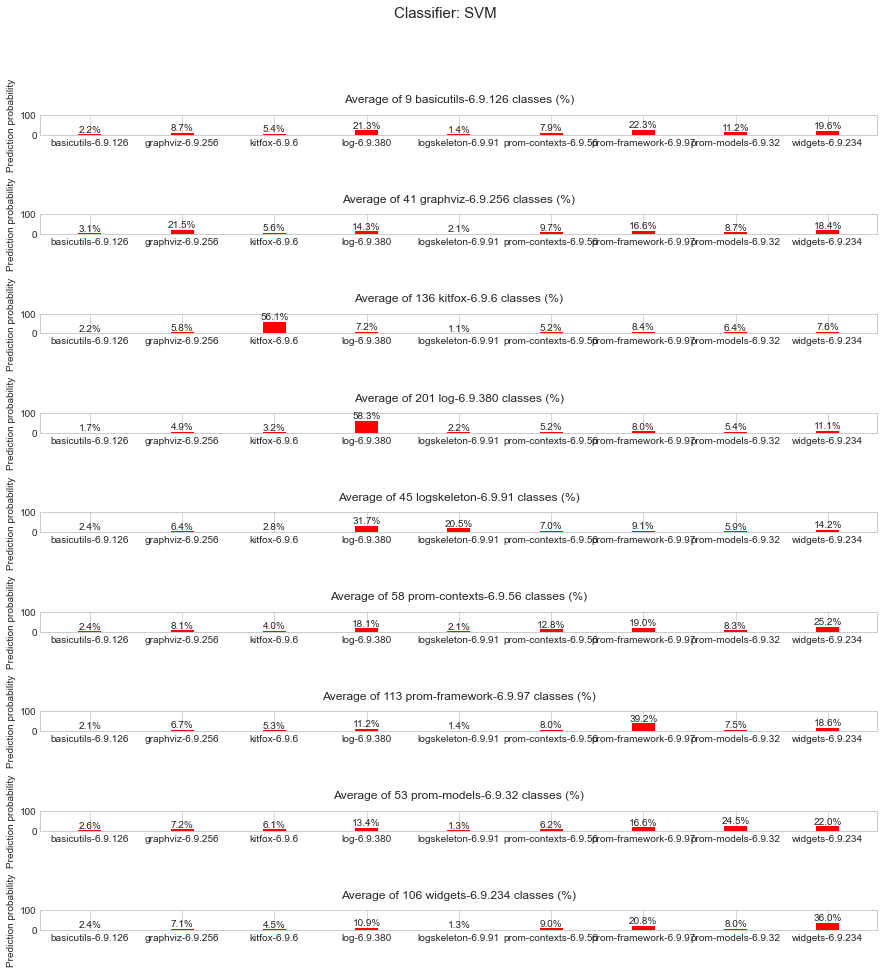

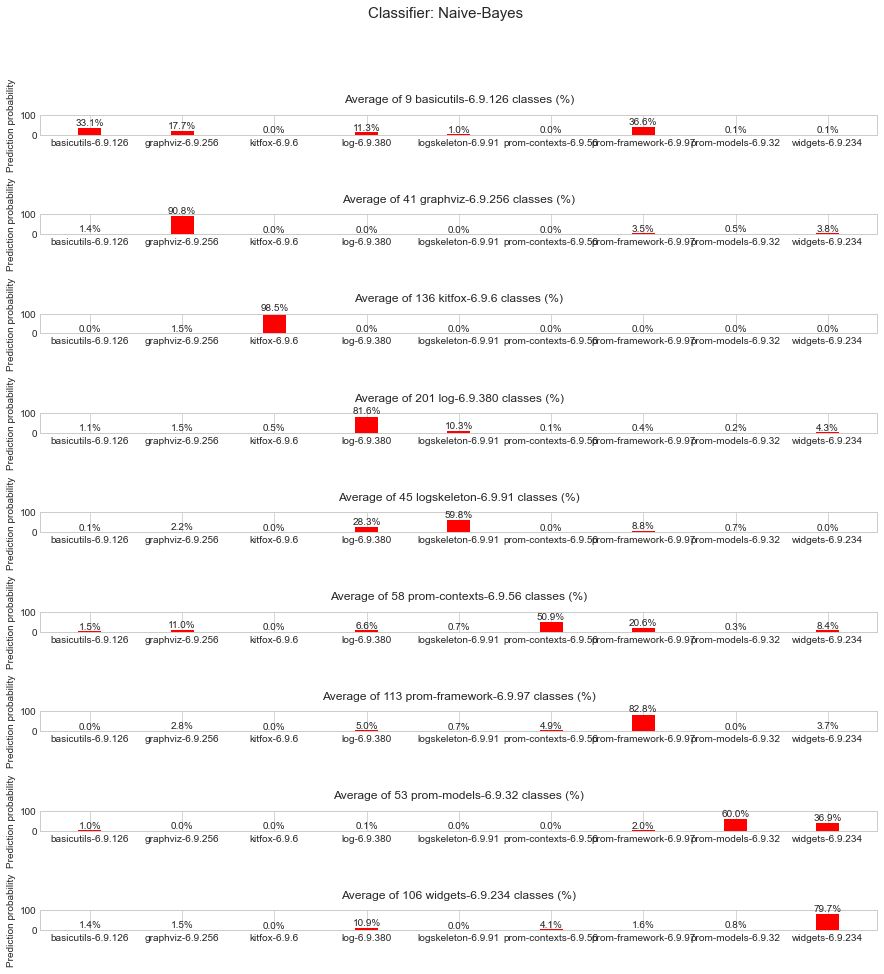

In [11]:
Graphs.plot_predictionScoreAverage(metrics_max_ent, classifier_max_ent)
Graphs.plot_predictionScoreAverage(metrics_svm, classifier_svm)
Graphs.plot_predictionScoreAverage(metrics_naive, classifier_naive)

In [12]:
df = metrics_svm.total_report_table()
df

,basicutils-6.9.126,graphviz-6.9.256,kitfox-6.9.6,log-6.9.380,logskeleton-6.9.91,prom-contexts-6.9.56,prom-framework-6.9.97,prom-models-6.9.32,widgets-6.9.234,accuracy,macro avg,weighted avg
precision,0.166667,0.900000,1.000000,0.877451,0.956522,0.487179,0.675000,0.903846,0.653061,0.801837,0.735525,0.807705
recall,0.222222,0.878049,0.985294,0.890547,0.488889,0.327586,0.955752,0.886792,0.603774,0.801837,0.693212,0.801837
f1-score,0.190476,0.888889,0.992593,0.883951,0.647059,0.391753,0.791209,0.895238,0.627451,0.801837,0.700958,0.795313
support,9.000000,41.000000,136.000000,201.000000,45.000000,58.000000,113.000000,53.000000,106.000000,0.801837,762.000000,762.000000
Test,9.000000,41.000000,136.000000,201.000000,45.000000,58.000000,113.000000,53.000000,106.000000,NaN,NaN,NaN
Train,1.000000,5.000000,15.000000,22.000000,5.000000,6.000000,12.000000,6.000000,12.000000,NaN,NaN,NaN
Total,10.000000,46.000000,151.000000,223.000000,50.000000,64.000000,125.000000,59.000000,118.000000,NaN,NaN,NaN
